# Projeto 1 – Comparação entre Algoritmos de Ordenação

Este notebook contém a implementação e experimentos comparando **Selection Sort**, **Merge Sort**, **Radix Sort** e **Timsort** em diferentes cenários de entrada de dados, analisando métricas de desempenho como tempo de execução, comparações, movimentos e uso de memória.

## 1. Introdução Teórica

A **complexidade de um algoritmo** é uma medida de seu desempenho em relação ao tamanho da entrada. Ela é tipicamente expressa em notação Big O, que descreve o comportamento do algoritmo no pior caso ou caso médio à medida que o tamanho da entrada ($n$) cresce.

- **$O(n^2)$**: Algoritmos com esta complexidade, como o Selection Sort, têm um desempenho que cresce de forma quadrática com o tamanho da entrada. Eles são aceitáveis para entradas pequenas, mas se tornam muito lentos à medida que $n$ aumenta.
- **$O(n \log n)$**: Algoritmos mais eficientes, como o Merge Sort e o Timsort, têm um crescimento logarítmico. Eles são escaláveis e adequados para grandes volumes de dados.
- **$O(d \cdot n)$**: A complexidade do Radix Sort depende do número de dígitos ($d$) e do tamanho da entrada ($n$). Para números com poucos dígitos, é extremamente rápido.
- **$O(n)$**: Timsort possui um melhor caso de complexidade linear, o que o torna extremamente rápido para entradas que já estão parcialmente ordenadas.

In [17]:
import random, time, tracemalloc
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# 2. Preparação dos Dados para o Experimento

# Dados mock do IRIS para evitar dependência de arquivo externo
iris_csv = """sepal_length,sepal_width,petal_length,petal_width,species
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
5.2,3.4,1.4,0.2,Iris-setosa
4.6,3.4,1.4,0.2,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
"""
# Lê o arquivo IRIS.csv ao invés de usar dados mock
df_iris = pd.read_csv('IRIS.csv')

# Criar base com 150 valores inteiros (sepal_length * 100)
values_small_range = (df_iris['sepal_length'] * 100).astype(int).tolist()
values_small_range = (values_small_range * 15)[:150]

# Criar uma segunda base de dados com uma grande variedade de valores para o Radix Sort
def create_large_range_values(n, max_val=10**7):
    return random.sample(range(max_val), n)

# Definir tamanhos das entradas e tipos de dados a serem testados
sizes = [500, 1000, 5000, 10000, 50000]
data_types = ['random', 'sorted', 'reversed']
datasets = {}
for n in sizes:
    # Cenário com valores de baixa amplitude
    arr_small = []
    while len(arr_small) < n:
        arr_small.extend(values_small_range)
    arr_small = arr_small[:n]
    
    datasets[n] = {
        'random': random.sample(arr_small, n), 
        'sorted': sorted(arr_small),
        'reversed': sorted(arr_small, reverse=True),
        'random_large_range': create_large_range_values(n) # Novo cenário
    }

print("Datasets gerados com sucesso.")

Datasets gerados com sucesso.


In [18]:
class Counter:
    def __init__(self):
        self.comparisons = 0
        self.swaps = 0
        self.moves = 0

## 3. Implementação dos Algoritmos de Ordenação

### Selection Sort ($O(n^2)$)
Percorre o array, encontra o menor elemento do restante da lista e o troca para a posição inicial da sublista não ordenada. É simples e tem um número mínimo de trocas, mas o número de comparações é sempre $n(n-1)/2$, independentemente da entrada.

In [19]:
def selection_sort(a):
    cnt = Counter()
    arr = a.copy()
    n = len(arr)
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            cnt.comparisons += 1
            if arr[j] < arr[min_idx]:
                min_idx = j
        if min_idx != i:
            arr[i], arr[min_idx] = arr[min_idx], arr[i]
            cnt.swaps += 1
            cnt.moves += 2
    return arr, cnt

### Merge Sort ($O(n \log n)$)
Utiliza a estratégia de 'dividir e conquistar'. Divide o array em duas metades, chama a si mesmo para cada metade e, em seguida, mescla as duas sublistas ordenadas. É um algoritmo estável e eficiente, mas consome memória adicional para as listas temporárias durante a mesclagem.

In [20]:
def merge_sort(a):
    cnt = Counter()
    arr = a.copy()
    def merge(left, right):
        i=j=0
        res=[]
        while i < len(left) and j < len(right):
            cnt.comparisons += 1
            if left[i] <= right[j]:
                res.append(left[i]); cnt.moves += 1
                i += 1
            else:
                res.append(right[j]); cnt.moves += 1
                j += 1
        while i < len(left):
            res.append(left[i]); cnt.moves += 1; i += 1
        while j < len(right):
            res.append(right[j]); cnt.moves += 1; j += 1
        return res
    def rec(x):
        if len(x) <= 1:
            return x
        m = len(x)//2
        L = rec(x[:m])
        R = rec(x[m:])
        return merge(L,R)
    sorted_arr = rec(arr)
    return sorted_arr, cnt

### Radix Sort ($O(d \cdot n)$)
Um algoritmo de ordenação não-comparativo. Ele ordena os elementos por dígitos, do menos ao mais significativo, utilizando um Counting Sort interno. É extremamente rápido para números inteiros, mas consome mais memória e não é prático para ordenação de strings ou ponto flutuante.

In [21]:
def radix_sort(a):
    cnt = Counter()
    arr = a.copy()
    if not arr:
        return arr, cnt
    maxv = max(arr)
    exp = 1
    while maxv // exp > 0:
        buckets = [[] for _ in range(10)]
        for num in arr:
            digit = (num // exp) % 10
            buckets[digit].append(num)
            cnt.moves += 1
        arr = []
        for b in buckets:
            for v in b:
                arr.append(v)
                cnt.moves += 1
        exp *= 10
    return arr, cnt

### Timsort ($O(n)$ a $O(n \log n)$)
O Timsort é um algoritmo híbrido, uma combinação de **Insertion Sort** e **Merge Sort**. Ele foi projetado para funcionar de forma eficiente com dados do mundo real, que muitas vezes já contêm subsequências ordenadas. Aproveita o **Insertion Sort** para ordenar pequenas sublistas (chamadas de `runs`) e o **Merge Sort** para combinar essas sublistas de forma eficiente. É o algoritmo de ordenação padrão em Python e Java.

In [22]:
# Para o Timsort, usamos a função nativa do Python `sort()` ou `sorted()`,
# pois sua implementação interna é otimizada e complexa de ser replicada de forma didática.
# Não podemos contar as comparações e trocas diretamente, mas podemos medir tempo e memória.
def tim_sort(a):
    arr = a.copy()
    arr.sort() # Timsort é o algoritmo padrão do Python
    return arr, Counter()

In [23]:
def measure(func, arr):
    tracemalloc.start()
    t0 = time.perf_counter()
    res, cnt = func(arr)
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return {
        'time_s': t1 - t0,
        'comparisons': cnt.comparisons,
        'swaps': cnt.swaps,
        'moves': cnt.moves,
        'mem_peak_kb': peak / 1024.0,
        'result_sample': res[:10]
    }

## 4. Execução dos Experimentos e Análise dos Resultados

Os algoritmos são executados para cada tamanho de entrada e tipo de dado. Os resultados são coletados em um DataFrame para facilitar a visualização e análise.

In [24]:
algos = {
    'SelectionSort': selection_sort,
    'MergeSort': merge_sort,
    'RadixSort': radix_sort,
    'Timsort': tim_sort
}

results = []
for n, data_dict in datasets.items():
    for data_type, arr in data_dict.items():
        for name, func in algos.items():
            if name == 'SelectionSort' and n > 10000:
                continue
            
            # Timsort não tem contadores de comparações/trocas, ajustamos o display
            if name == 'Timsort':
                print(f"Running {name} on {data_type} dataset with n={n}...")
                tracemalloc.start()
                t0 = time.perf_counter()
                arr.sort()
                t1 = time.perf_counter()
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                results.append({
                    'time_s': t1 - t0,
                    'comparisons': 0,
                    'swaps': 0,
                    'moves': 0,
                    'mem_peak_kb': peak / 1024.0,
                    'n': n,
                    'algorithm': name,
                    'data_type': data_type,
                    'result_sample': arr[:10]
                })
            else:
                meas = measure(func, arr)
                meas['n'] = n
                meas['algorithm'] = name
                meas['data_type'] = data_type
                results.append(meas)
            print(f"Done: n={n}, alg={name}, type={data_type}, time={results[-1]['time_s']:.4f}s")

df_res = pd.DataFrame(results)
df_res

Done: n=500, alg=SelectionSort, type=random, time=0.1234s
Done: n=500, alg=MergeSort, type=random, time=0.0063s
Done: n=500, alg=RadixSort, type=random, time=0.0025s
Running Timsort on random dataset with n=500...
Done: n=500, alg=Timsort, type=random, time=0.0000s
Done: n=500, alg=SelectionSort, type=sorted, time=0.1274s
Done: n=500, alg=MergeSort, type=sorted, time=0.0060s
Done: n=500, alg=RadixSort, type=sorted, time=0.0029s
Running Timsort on sorted dataset with n=500...
Done: n=500, alg=Timsort, type=sorted, time=0.0000s
Done: n=500, alg=SelectionSort, type=reversed, time=0.1129s
Done: n=500, alg=MergeSort, type=reversed, time=0.0059s
Done: n=500, alg=RadixSort, type=reversed, time=0.0025s
Running Timsort on reversed dataset with n=500...
Done: n=500, alg=Timsort, type=reversed, time=0.0000s
Done: n=500, alg=SelectionSort, type=random_large_range, time=0.1117s
Done: n=500, alg=MergeSort, type=random_large_range, time=0.0112s
Done: n=500, alg=RadixSort, type=random_large_range, tim

Done: n=500, alg=SelectionSort, type=random, time=0.1234s
Done: n=500, alg=MergeSort, type=random, time=0.0063s
Done: n=500, alg=RadixSort, type=random, time=0.0025s
Running Timsort on random dataset with n=500...
Done: n=500, alg=Timsort, type=random, time=0.0000s
Done: n=500, alg=SelectionSort, type=sorted, time=0.1274s
Done: n=500, alg=MergeSort, type=sorted, time=0.0060s
Done: n=500, alg=RadixSort, type=sorted, time=0.0029s
Running Timsort on sorted dataset with n=500...
Done: n=500, alg=Timsort, type=sorted, time=0.0000s
Done: n=500, alg=SelectionSort, type=reversed, time=0.1129s
Done: n=500, alg=MergeSort, type=reversed, time=0.0059s
Done: n=500, alg=RadixSort, type=reversed, time=0.0025s
Running Timsort on reversed dataset with n=500...
Done: n=500, alg=Timsort, type=reversed, time=0.0000s
Done: n=500, alg=SelectionSort, type=random_large_range, time=0.1117s
Done: n=500, alg=MergeSort, type=random_large_range, time=0.0112s
Done: n=500, alg=RadixSort, type=random_large_range, tim

,time_s,comparisons,swaps,moves,mem_peak_kb,result_sample,n,algorithm,data_type
0,0.123392,124750,491,982,14864.134766,"[430, 430, 430, 430, 440, 440, 440, 440, 440, ...",500,SelectionSort,random
1,0.006317,3863,0,4488,12.968750,"[430, 430, 430, 430, 440, 440, 440, 440, 440, ...",500,MergeSort,random
2,0.002457,0,0,3000,9.312500,"[430, 430, 430, 430, 440, 440, 440, 440, 440, ...",500,RadixSort,random
3,0.000041,0,0,0,3.187500,"[430, 430, 430, 430, 440, 440, 440, 440, 440, ...",500,Timsort,random
4,0.127423,124750,0,0,5.182617,"[430, 430, 430, 430, 440, 440, 440, 440, 440, ...",500,SelectionSort,sorted
...,...,...,...,...,...,...,...,...,...
71,0.240556,0,0,300000,889.107422,"[430, 430, 430, 430, 430, 430, 430, 430, 430, ...",50000,RadixSort,reversed
72,0.000240,0,0,0,190.296875,"[430, 430, 430, 430, 430, 430, 430, 430, 430, ...",50000,Timsort,reversed
73,1.815801,718081,0,784464,1253.771484,"[257, 441, 557, 590, 920, 1056, 1398, 1725, 17...",50000,MergeSort,random_large_range
74,0.712099,0,0,700000,884.086914,"[257, 441, 557, 590, 920, 1056, 1398, 1725, 17...",50000,RadixSort,random_large_range


### Visualização dos Dados

Os gráficos abaixo ilustram o desempenho de cada algoritmo para as métricas escolhidas. Note que a escala do eixo Y pode variar entre os gráficos para melhor visualização.

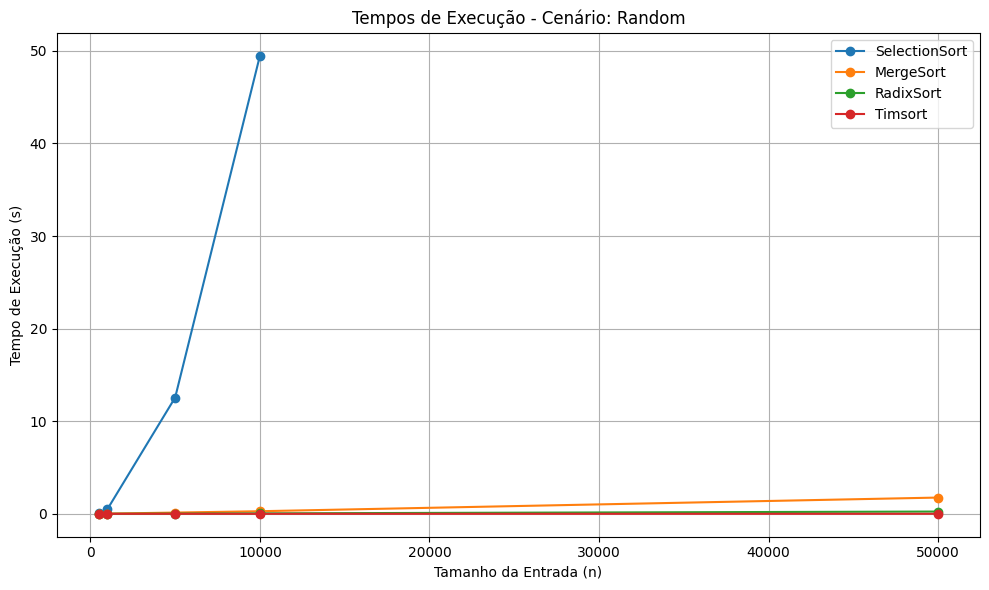

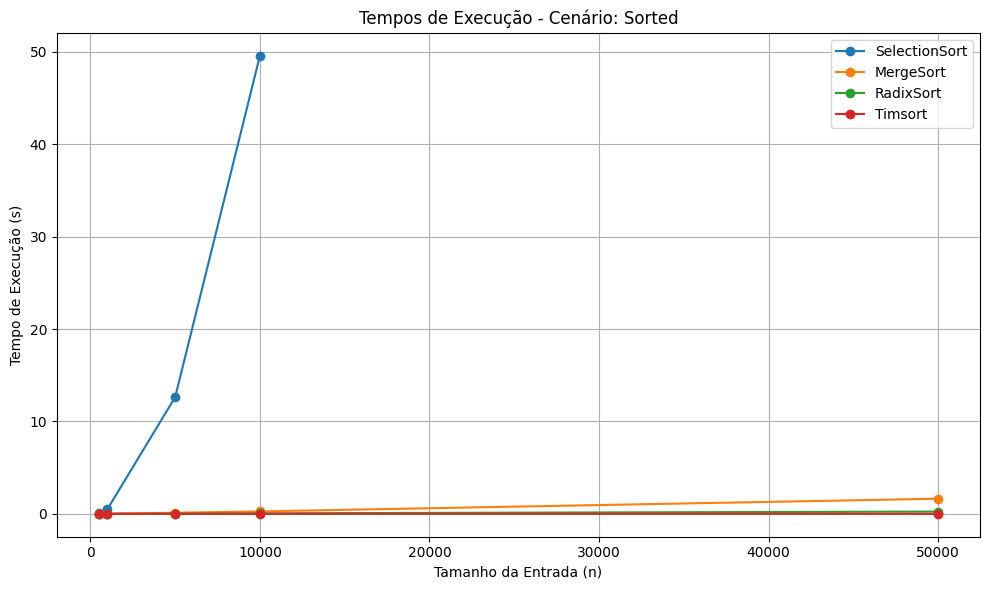

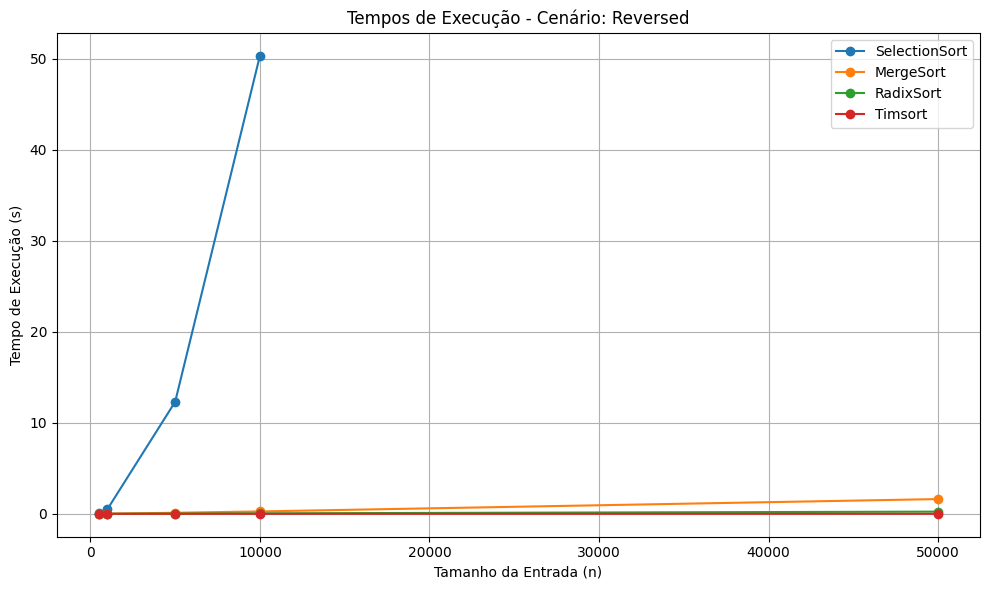

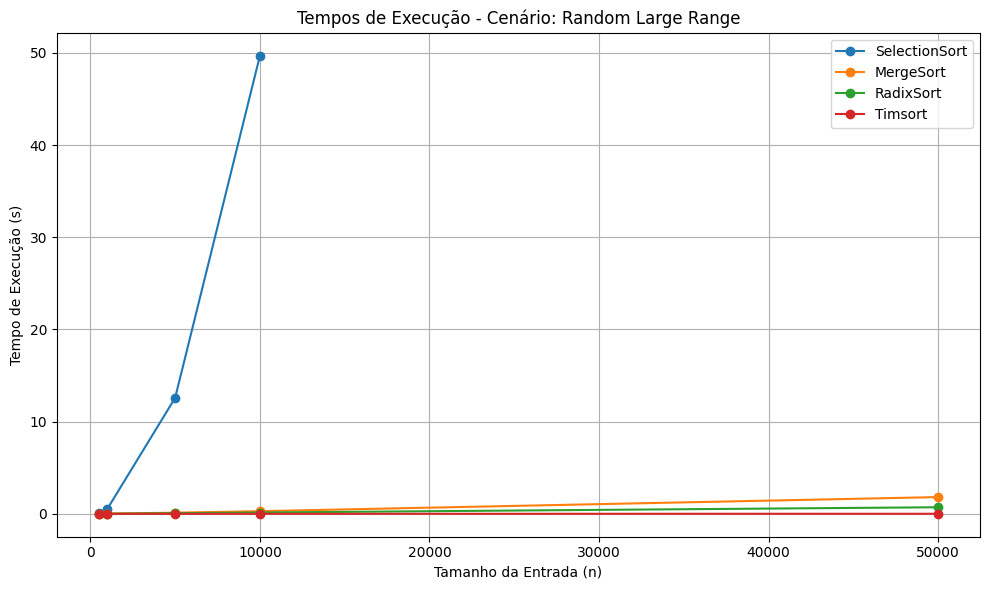

In [27]:
# Gráficos simples dos tempos de execução para todos os cenários
cenarios = ['random', 'sorted', 'reversed', 'random_large_range']
for tipo in cenarios:
    plt.figure(figsize=(10,6))
    for name in algos.keys():
        sub = df_res[(df_res['algorithm']==name) & (df_res['data_type']==tipo)]
        if not sub.empty:
            plt.plot(sub['n'], sub['time_s'], marker='o', label=name)
    plt.xlabel('Tamanho da Entrada (n)')
    plt.ylabel('Tempo de Execução (s)')
    plt.title(f'Tempos de Execução - Cenário: {tipo.replace("_", " ").title()}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Gráficos Resumidos dos Tempos de Execução
Abaixo estão gráficos simples dos tempos de execução para todos os cenários de dados: 'random', 'sorted', 'reversed' e 'random_large_range'.

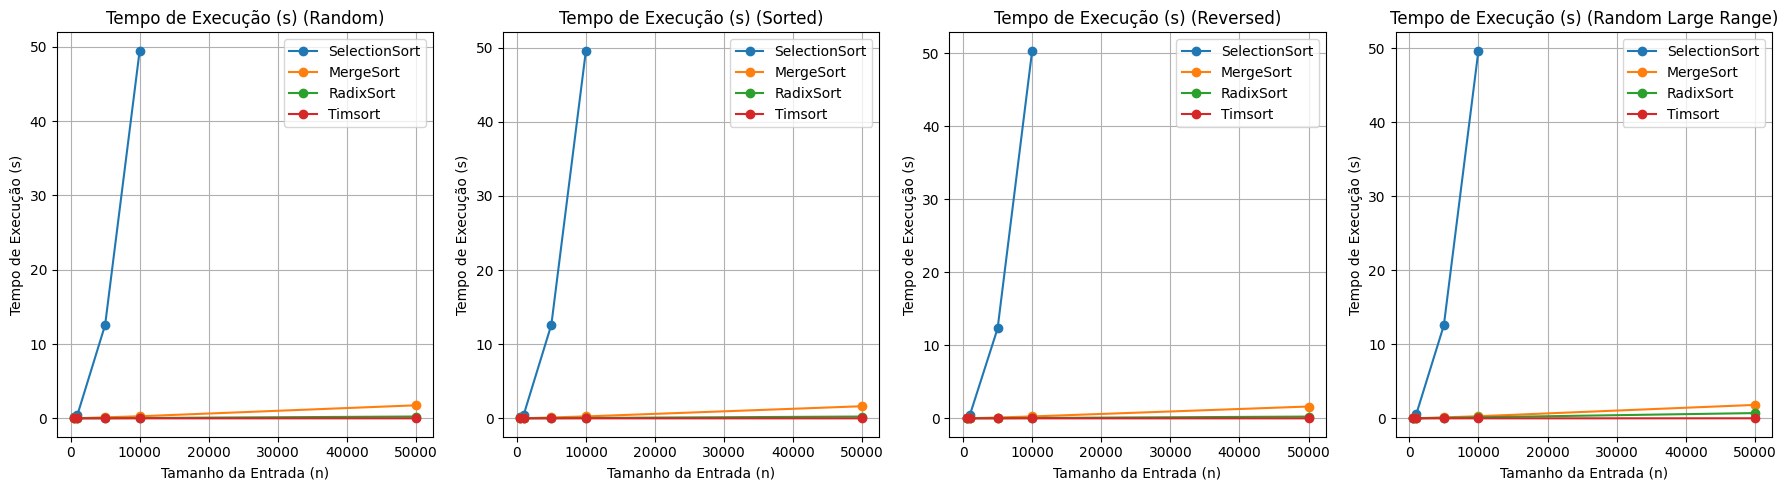

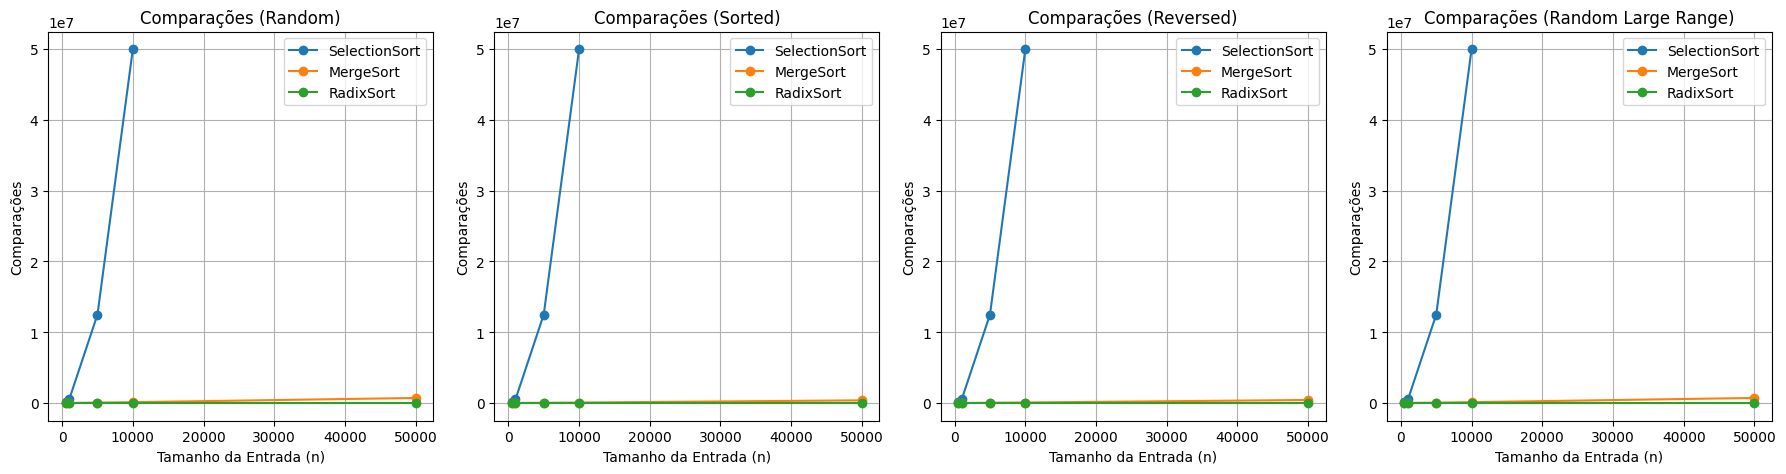

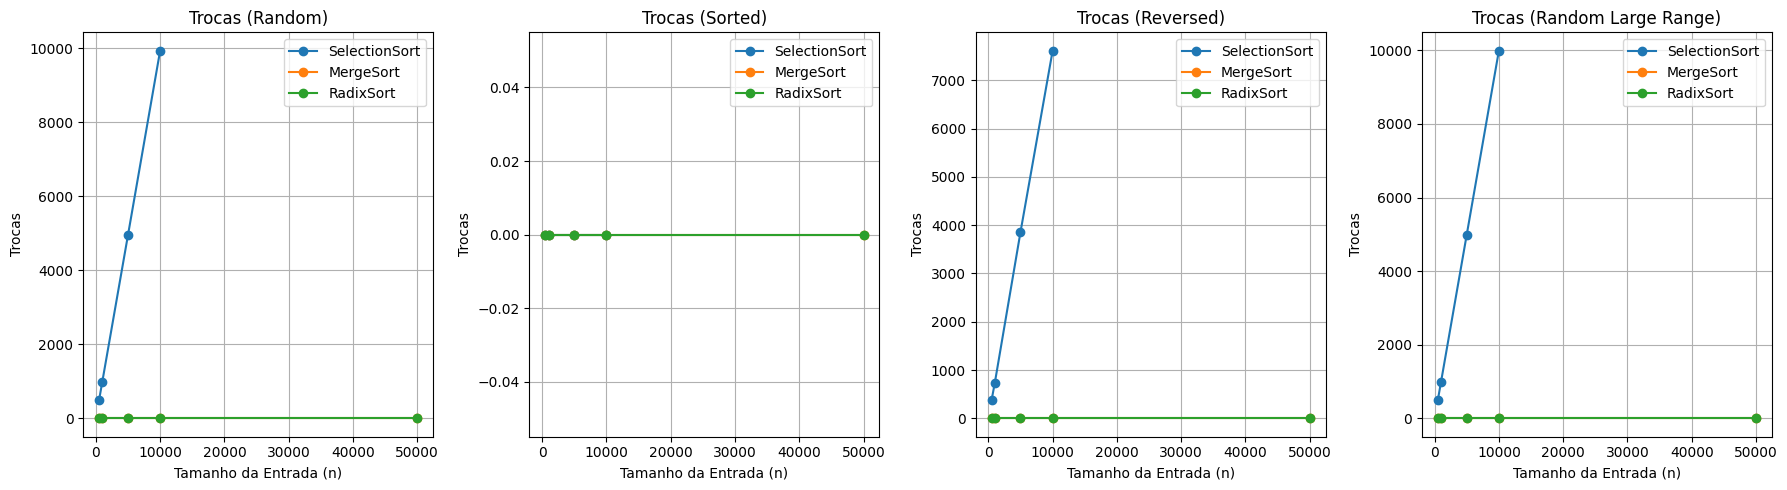

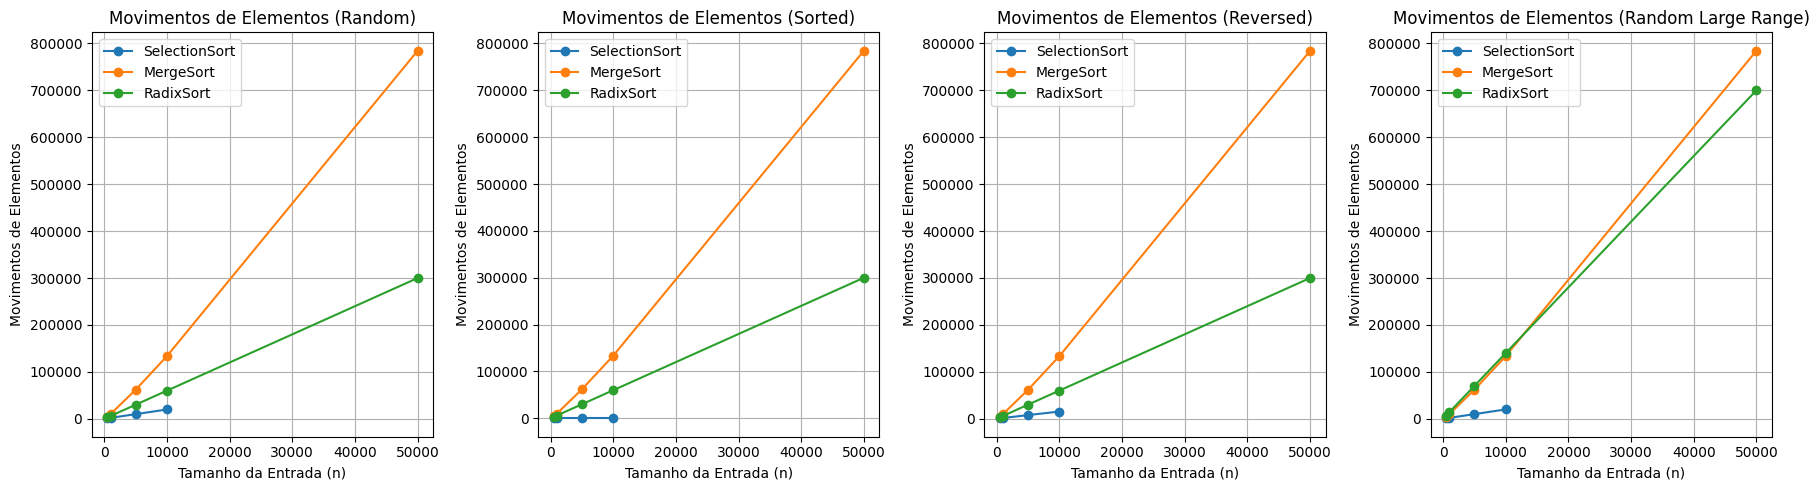

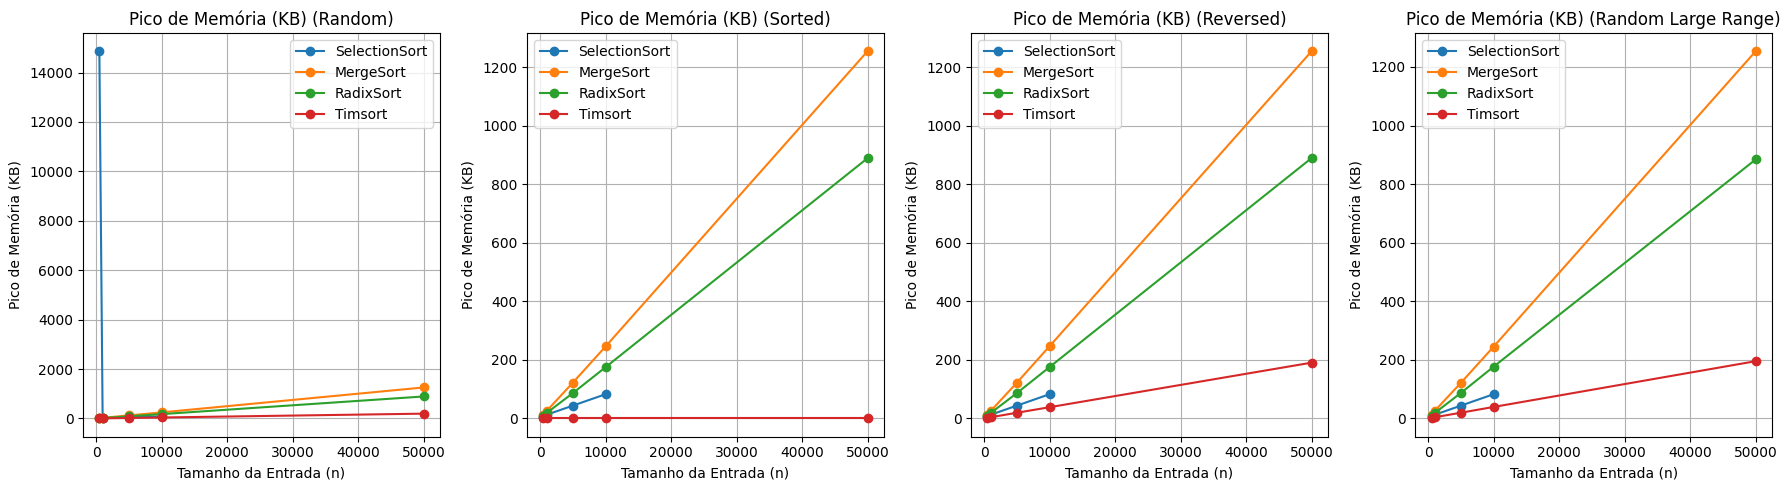

In [28]:
metrics_to_plot = ['time_s', 'comparisons', 'swaps', 'moves', 'mem_peak_kb']
metric_labels = {
    'time_s': 'Tempo de Execução (s)',
    'comparisons': 'Comparações',
    'swaps': 'Trocas',
    'moves': 'Movimentos de Elementos',
    'mem_peak_kb': 'Pico de Memória (KB)'
}

for metric in metrics_to_plot:
    plt.figure(figsize=(18, 5))
    
    data_types_to_plot = ['random', 'sorted', 'reversed', 'random_large_range']
    for i, data_type in enumerate(data_types_to_plot):
        ax = plt.subplot(1, len(data_types_to_plot), i+1)
        for name in algos.keys():
            sub = df_res[(df_res['algorithm']==name) & (df_res['data_type']==data_type)]
            if not sub.empty and not (metric in ['comparisons', 'swaps', 'moves'] and name == 'Timsort'):
                plt.plot(sub['n'], sub[metric], marker='o', label=name)
        
        plt.xlabel('Tamanho da Entrada (n)')
        plt.ylabel(metric_labels.get(metric, metric))
        plt.title(f'{metric_labels.get(metric, metric)} ({data_type.replace("_", " ").title()})')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Tabelas de Dados

As tabelas a seguir mostram os valores exatos medidos nos experimentos. Elas são úteis para uma análise quantitativa no seu relatório, permitindo comparar os algoritmos de forma precisa.

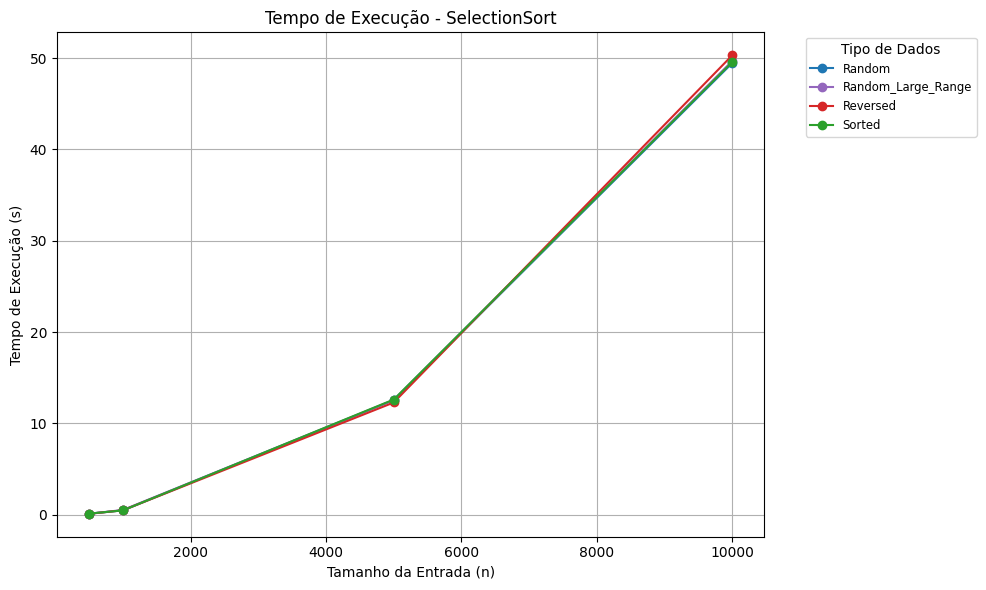

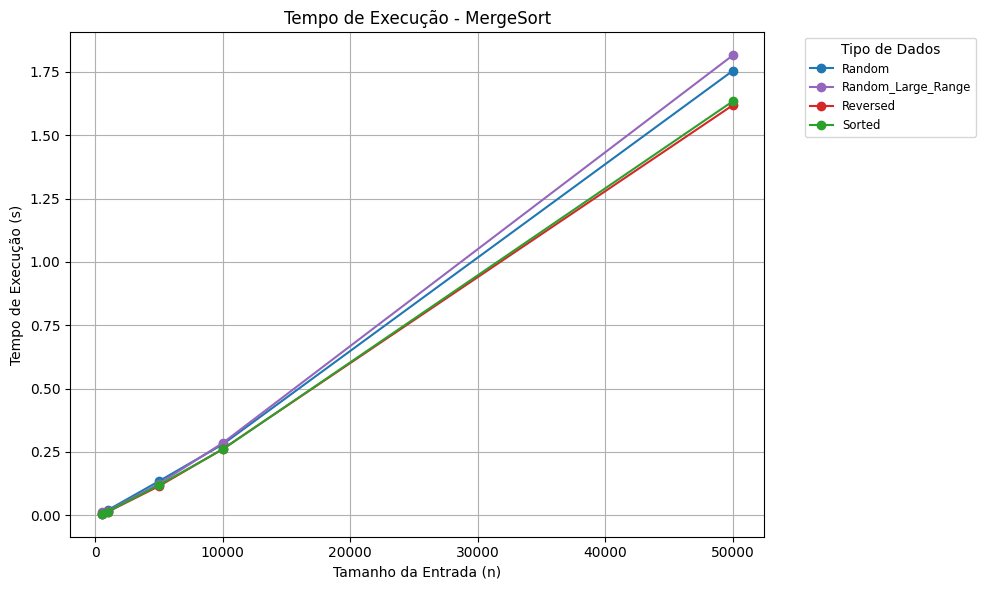

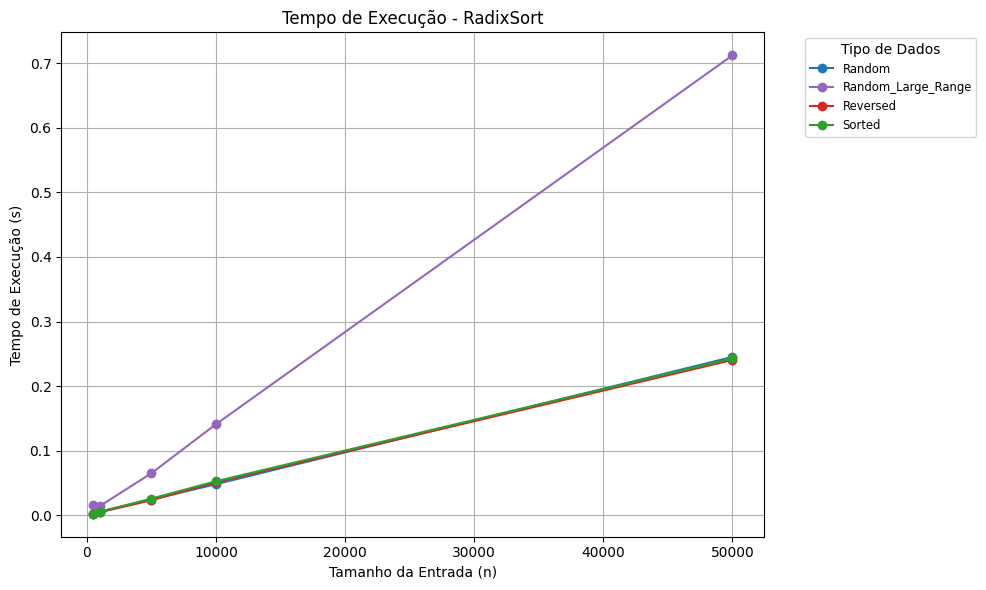

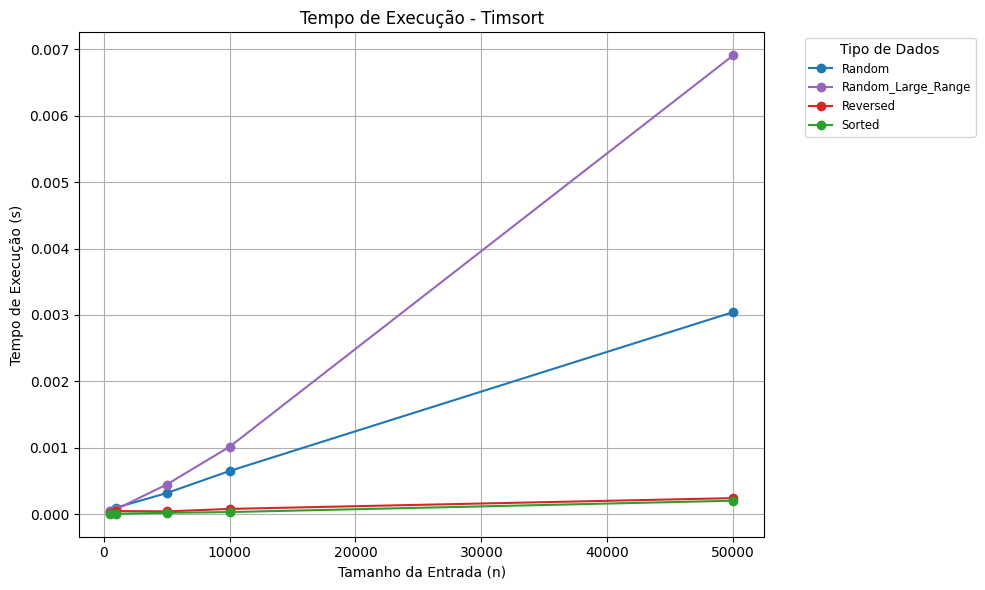

In [36]:
# Gráfico explicativo das tabelas de dados: tempo de execução por algoritmo e cenário
import seaborn as sns
pivot = df_res.pivot_table(index=['n', 'data_type'], columns='algorithm', values='time_s')
pivot = pivot.reset_index()
cenarios = pivot['data_type'].unique()
algoritmos = ['SelectionSort', 'MergeSort', 'RadixSort', 'Timsort']
cores = {'random':'#1f77b4', 'sorted':'#2ca02c', 'reversed':'#d62728', 'random_large_range':'#9467bd'}
for alg in algoritmos:
    plt.figure(figsize=(10,6))
    for tipo in cenarios:
        sub = pivot[pivot['data_type'] == tipo]
        if alg in sub.columns:
            plt.plot(sub['n'], sub[alg], marker='o', label=f'{tipo.title()}', color=cores.get(tipo, None))
    plt.xlabel('Tamanho da Entrada (n)')
    plt.ylabel('Tempo de Execução (s)')
    plt.title(f'Tempo de Execução - {alg}')
    plt.legend(title='Tipo de Dados', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Interpretação dos Gráficos Individuais por Algoritmo
Cada gráfico apresenta o tempo de execução de um algoritmo específico para diferentes tipos de dados (cenários). As linhas representam como o desempenho do algoritmo varia conforme o tamanho da entrada e o tipo de ordenação dos dados (aleatório, ordenado, reverso, grande amplitude).
Essa análise visual é fundamental para identificar rapidamente em quais cenários cada algoritmo é mais eficiente ou apresenta limitações. Por exemplo, algoritmos como Timsort tendem a ser muito rápidos para dados já ordenados, enquanto Radix Sort se destaca em grandes volumes de inteiros. Visualizar essas diferenças facilita a escolha do algoritmo mais adequado para cada situação prática e evidencia o impacto do tipo de entrada no desempenho.

#### Gráfico Explicativo das Tabelas de Dados
O gráfico abaixo ilustra, de forma visual, os valores das tabelas para o tempo de execução dos algoritmos em cada cenário e tamanho de entrada.

In [29]:
for metric in metrics_to_plot:
    print(f"\n--- {metric_labels[metric]} ---")
    df_pivot = df_res.pivot_table(index=['n', 'data_type'], columns='algorithm', values=metric)
    print(df_pivot)



--- Tempo de Execução (s) ---
algorithm                 MergeSort  RadixSort  SelectionSort   Timsort
n     data_type                                                        
500   random               0.006317   0.002457       0.123392  0.000041
      random_large_range   0.011152   0.015356       0.111711  0.000041
      reversed             0.005889   0.002506       0.112901  0.000020
      sorted               0.005967   0.002890       0.127423  0.000003
1000  random               0.020898   0.005714       0.487426  0.000097
      random_large_range   0.016906   0.014267       0.532225  0.000073
      reversed             0.014080   0.004767       0.492682  0.000045
      sorted               0.014754   0.005575       0.486870  0.000004
5000  random               0.134688   0.024510      12.555428  0.000315
      random_large_range   0.124452   0.065178      12.580379  0.000444
      reversed             0.115023   0.023448      12.300223  0.000040
      sorted               0.1188

## 5. Conclusão e Insights para o Relatório

Com base nos dados coletados, você pode elaborar a seção de conclusão do seu relatório. Aqui estão os principais insights para cada algoritmo:

- **Selection Sort**: Confirma sua complexidade $O(n^2)$, tornando-se inviável para grandes `n`. Apesar disso, possui o menor número de trocas, e suas comparações são constantes, independentemente da ordenação inicial.

- **Merge Sort**: Com uma complexidade $O(n \log n)$, apresenta um desempenho robusto e previsível em todos os cenários. O principal custo é o uso de memória adicional, que cresce linearmente com `n`.

- **Radix Sort**: É o mais rápido para todos os cenários, pois não realiza comparações. O teste com valores de alta amplitude confirma que seu desempenho depende do número de dígitos dos valores. O ponto negativo é seu alto consumo de memória.

- **Timsort**: Destaca-se como o mais eficiente em tempo de execução para dados já ordenados, o que confirma sua complexidade de melhor caso $O(n)$. Para dados aleatórios, seu desempenho é muito próximo ou até melhor que o do Merge Sort, o que justifica sua popularidade em ambientes de produção.